In [1]:
import pickle
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mimiciv_preprocessed_path = "/cis/home/xhan56/mimic-ts/XY_dl_data.pkl"
mimiciv_ditems_path = "/cis/home/xhan56/mimic-ts/d_items.csv"

In [3]:
ditems = pd.read_csv(mimiciv_ditems_path)

In [4]:
# make a dictionary of itemid to label
itemid_to_label = dict(zip(ditems["itemid"], ditems["label"]))

In [5]:
print(f"Number of unique label in ditems: {ditems['label'].nunique()}")
print(f"Total rows in ditems: {len(ditems)}")
ditems

Number of unique label in ditems: 3965
Total rows in ditems: 4095


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220001,Problem List,Problem List,chartevents,General,NaN,Text,NaN,NaN
1,220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,NaN,Date and time,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,NaN,NaN
4,220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4090,230172,Patient Reversed,Patient Reversed,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4091,230173,Patient - Fast Track Protocol,Patient - Fast Track Protocol,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4092,230174,Nerve block in OR,Nerve block in OR,procedureevents,3-Significant Events,None,Processes,NaN,NaN
4093,230176,IUC Stabilization Device,IUC Stabilization Device,chartevents,GI/GU,NaN,Checkbox,NaN,NaN


In [6]:
mimiciv = pickle.load(open(mimiciv_preprocessed_path, "rb"))

## Filter By Column

In [7]:
# find the dimensions/features/columns of the meds time series with the most non-zero values
med_column_idx_sorted_by_nonzero_vals = torch.argsort((mimiciv["meds"] != 0).sum(dim=[0, 1]), descending=True)

num_selected_cols = 10
for column_idx in med_column_idx_sorted_by_nonzero_vals[:num_selected_cols]:
    column_num = int(mimiciv["keys_to_cols"]["MEDS"][column_idx])
    column_name = itemid_to_label[column_num]
    batch_timeseries = mimiciv["meds"][:, :, column_idx]
    nonzero_ratio = (batch_timeseries != 0).sum(dim=[0, 1]) / batch_timeseries.shape[0] / batch_timeseries.shape[1]
    print(column_num, column_name, round(nonzero_ratio.item(), 3))
    # print(column_name)

    

225158 NaCl 0.9% 0.353
220949 Dextrose 5% 0.222
225152 Heparin Sodium 0.089
225943 Solution 0.065
222168 Propofol 0.046
225828 LR 0.041
225823 D5 1/2NS 0.032
228340 Furosemide (Lasix) 250/50 0.021
223258 Insulin - Regular 0.021
225936 Replete with Fiber (Full) 0.018


In [8]:
# find the dimensions/features/columns of the chart time series with the most non-zero values
chart_column_idx_sorted_by_nonzero_vals = torch.argsort((mimiciv["chart"] != 0).sum(dim=[0, 1]), descending=True)

num_selected_cols = 20
for column_idx in chart_column_idx_sorted_by_nonzero_vals[:num_selected_cols]:
    column_num = int(mimiciv["keys_to_cols"]["CHART"][column_idx])
    column_name = itemid_to_label[column_num]
    batch_timeseries = mimiciv["chart"][:, :, column_idx]
    nonzero_ratio = (batch_timeseries != 0).sum(dim=[0, 1]) / batch_timeseries.shape[0] / batch_timeseries.shape[1]
    print(column_num, column_name, round(nonzero_ratio.item(), 3))
    # print(column_name)
    

220045 Heart Rate 0.999
220277 O2 saturation pulseoxymetry 0.999
220046 Heart rate Alarm - High 0.997
220047 Heart Rate Alarm - Low 0.997
220210 Respiratory Rate 0.997
223770 O2 Saturation Pulseoxymetry Alarm - Low 0.996
224161 Resp Alarm - High 0.996
223769 O2 Saturation Pulseoxymetry Alarm - High 0.996
224162 Resp Alarm - Low 0.996
223761 Temperature Fahrenheit 0.995
226253 SpO2 Desat Limit 0.995
220645 Sodium (serum) 0.992
227442 Potassium (serum) 0.992
220602 Chloride (serum) 0.992
225624 BUN 0.992
227443 HCO3 (serum) 0.992
220621 Glucose (serum) 0.992
227073 Anion gap 0.992
220545 Hematocrit (serum) 0.99
220635 Magnesium 0.99


### Asked ChatGPT o3 does any of the medications have causal effects on any of the chart events
* Regular insulin
    * Glucose (serum)
    * Potassium (serum)
* Furosemide (Lasix)
    * Potassium (serum)
    * Magnesium (serum)
    * BUN
* 0.9% Sodium Chloride
    * Sodium (serum)
    * Chloride (serum)
* 5% Dextrose in water (D5W)
    * Glucose (serum)
    * Sodium (serum)
* Heparin (continuous />= 4 days)
    * Potassium (serum)
* Propofol infusion
    * Respiratory rate
    * O2 Saturation
* Lactated Ringer's (LR)
    * Bicarbonate
    * Potassium

Therefore, we pick the following chart events:
* Glucose (serum)
* Potassium (serum)
* Magnesium (serum)
* BUN

and the following medications:
* Regular insulin
* Furosemide (Lasix)

In [ ]:
selected_med_column_nums = [223258, # insulin
                            228340, # furosemide (lasix)
                            # 225158, # 0.9% sodium chloride,
                            # 220949, # 5% dextrose in water (d5w)
                            # 225152, # heparin (continuous >= 4 days)
                            # 222168, # propofol infusion
                            # 225828, # lactated ringer's (lr)
                            ]
 
selected_chart_column_nums = [220621, # glucose (serum)
                              227442, # potassium (serum)
                              220635, # magnesium (serum)
                              225624, # BUN
                            #   220645, # sodium (serum)
                            #   220602, # chloride (serum)
                            #   220210, # respiratory rate
                            #   220277, # o2 saturation
                            #   227443, # bicarbonate (hco3)
                            #   227442, # pottasium (serum)
                              ]



## Check MIMIC-IV RUS Results
**Q**: Which ones of the following have a stronger effect on a person's Potassium level few hours later? How would you rank them: Insulin medication, Furosemide medication, current Glucose level, current Potassium level, current Magnesium level, and current Blood Urea Nitrogen (BUN)?


**A (ChatGPT o3)**:

Quick ranking for their influence on serum potassium over the next few hours
(strongest → weakest, assuming an otherwise-stable adult with normal kidneys and acid-base status):

1. Insulin medication

2. Current serum potassium concentration itself

3. Furosemide (loop-diuretic) dose

4. Current glucose level

5. Current magnesium level

6. Current blood urea nitrogen (BUN)







In [10]:
mimiciv_rus_results = np.load("/cis/home/xhan56/code/dami/results/mimiciv/mimiciv_lag6_bins8_thresh0.3.npy", allow_pickle=True)


/tmp/ipykernel_31501/2169741371.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


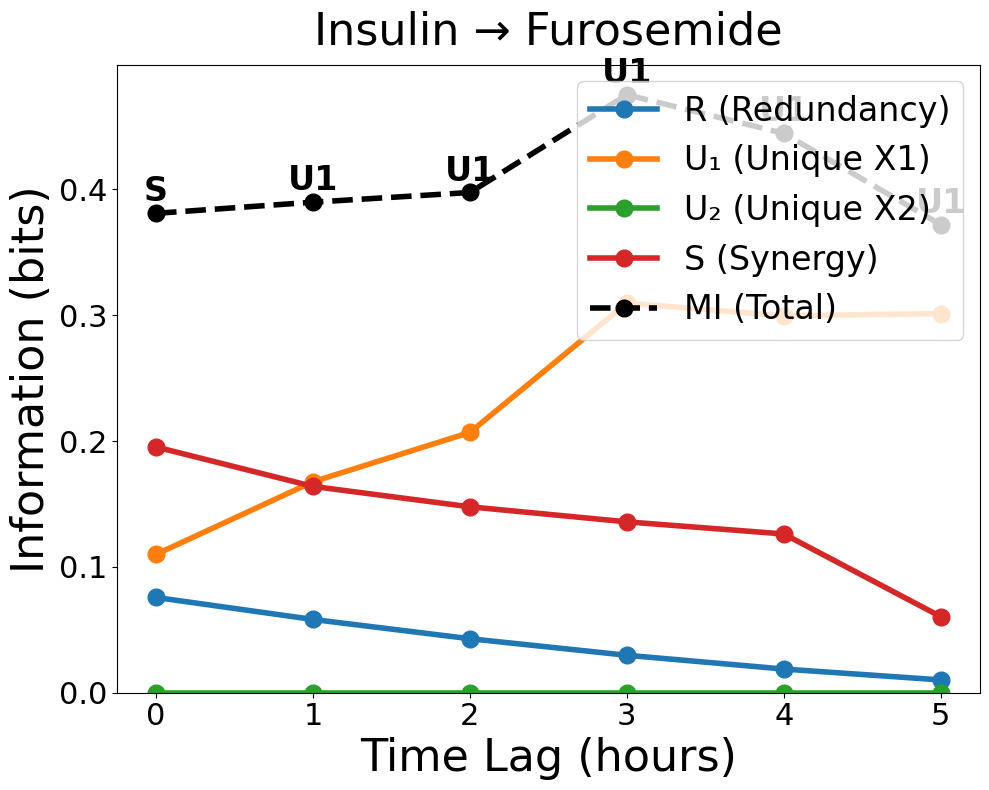

In [21]:
# mimiciv_rus_results[0:6]
def plot_multi_lag_results(feature_pair_data, feature_pair_name, ax=None):
    """
    Plot RUS decomposition results for different lags of a feature pair.
    
    Args:
        feature_pair_data: Array of dictionaries containing RUS results for different lags
        feature_pair_name: String name of the feature pair for the title
        ax: Matplotlib axis object (optional)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract data for plotting
    lags = [item['lag'] for item in feature_pair_data]
    r_values = [item['R_value'] for item in feature_pair_data]
    u1_values = [item['U1_value'] for item in feature_pair_data]
    u2_values = [item['U2_value'] for item in feature_pair_data]
    s_values = [item['S_value'] for item in feature_pair_data]
    mi_values = [r + u1 + u2 + s for r, u1, u2, s in zip(r_values, u1_values, u2_values, s_values)]
    
    # Create the line plot
    ax.plot(lags, r_values, 'o-', label='R (Redundancy)', linewidth=4, markersize=12)
    ax.plot(lags, u1_values, 'o-', label='U₁ (Unique X1)', linewidth=4, markersize=12)
    ax.plot(lags, u2_values, 'o-', label='U₂ (Unique X2)', linewidth=4, markersize=12)
    ax.plot(lags, s_values, 'o-', label='S (Synergy)', linewidth=4, markersize=12)
    ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)
    
    # Annotate the dominant term
    for i, item in enumerate(feature_pair_data):
        dom_term = item['dominant_term']
        # Position the annotation slightly higher above the MI value
        ax.annotate(dom_term, (lags[i], mi_values[i] + 0.02 * max(mi_values)), 
                   xytext=(0, 0), textcoords='offset points',
                   ha='center', fontweight='bold', fontsize=24)
    
    # Add labels and title
    ax.set_xlabel('Time Lag (hours)', fontsize=32)
    ax.set_ylabel('Information (bits)', fontsize=32)
    ax.set_title(f"{feature_pair_name}", fontsize=32, pad=15)
    
    # Add legend and grid
    ax.legend(loc='upper right', fontsize=24)
    # ax.grid(True, linestyle='--', alpha=0.7)
    # Set x and y ticks font size
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    return ax

# Extract the first feature pair and plot
first_pair_data = mimiciv_rus_results[0:6]
if len(first_pair_data) > 0:
    # pair_name = f"{first_pair_data[0]['feature_pair'][0]} → {first_pair_data[0]['feature_pair'][1]}"
    pair_name = "Insulin → Furosemide"
    fig, ax = plt.subplots(figsize=(10, 8))
    plot_multi_lag_results(first_pair_data, pair_name, ax)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_31501/2169741371.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(lags, mi_values, 'o-', label='MI (Total)', linewidth=4, color='black', linestyle='--', markersize=12)


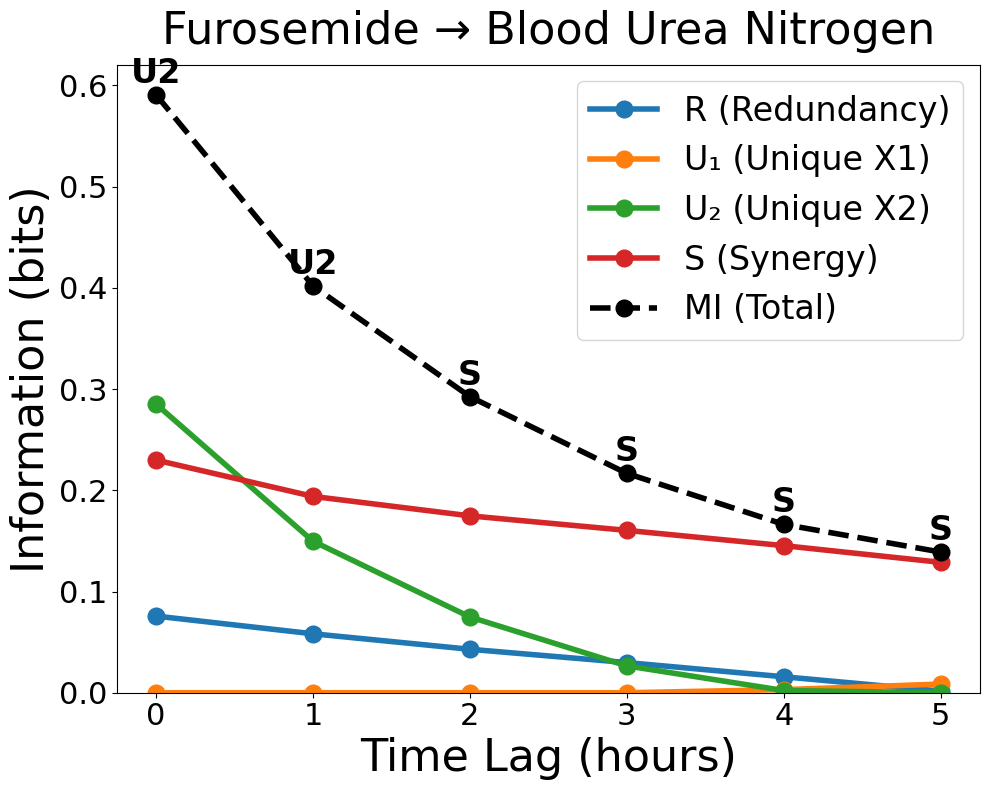

In [22]:
feat_pair = mimiciv_rus_results[48:54]
# pair_name = f"{feat_pair[0]['feature_pair'][0]} → {feat_pair[0]['feature_pair'][1]}"
pair_name = "Furosemide → Blood Urea Nitrogen"
fig, ax = plt.subplots(figsize=(10, 8))
plot_multi_lag_results(feat_pair, pair_name, ax)
plt.tight_layout()
plt.show()